# Schémas pour BoT

On part de l'équation cinétique suivante :

$$
    \partial_t f + v\partial_x f + E\partial_v f = 0
$$

le champ $E$ peut être évalué soit via l'équation de Poisson ou d'Ampère, et la condition initiale est celle d'un *bump on tail*.

Première chose que l'on effectue est une décomposition de $f = f_b + f_h$ correspondant à :

* $f_b$ est l'ensemble des particules froides formant la majorité de la masse du problème (*bulk*)
* $f_h$ est l'ensemble des particles chaudes (*hot*)

Le problème peut se décomposer comme suit :

$$
    \begin{cases}
        \partial_t f_b + v\partial_x f_b + E\partial_v f_b = 0 \\
        \partial_t f_h + v\partial_x f_h + E\partial_v f_h = 0
    \end{cases}
$$

Il est à noter que le champ électrique $E$ est le même pour les deux équations (qui sont donc couplées) et qu'il est calculé à partir de la densité totale $\rho = \int f_b+f_h\,\mathrm{d}v$.

> On remarque qu'un couple de fonction $f_b$ et $f_h$ vérifiant l'équation induite par cette décomposition vérifiera l'équation cinétique, mais cela n'indique pas comment calculer $f_b$ et $f_h$. Il est fort probable que tout couple de fonctions $(f_1,f_2)$ tel que $f = f_1+f_2$ ne vérifie pas nécessairement cette décomposition.


## FFT - IFRK3

On se retrouve à devoir résoudre 2 équations cinétiques, la première idée a été d'effectuer du *mM* sur $f_b$ et de ne l'approximer qu'à sa partie *macro*. Cela ne fonctionne pas nécessairement très bien car la décomposition *mM* impose d'avoir $\int g\,\mathrm{d}v = 0$, or le cas du *bump on tail*, la bosse rajoutée sur la queue n'est pas de masse nulle.

Pour résoudre une des équations cinétiques on peut effectuer une transformée de Fourier puis effectuer un schéma exponentielle type RK3 exponentiel (IFRK3 pour *integrating factor Runge-Kutta method*) ou Lawson pour résoudre le problème en temps. La résolution via une FFT est envisageable en espace grâce à des condtions aux bords périodiques (ce qui était déjà fait pour la résolution de l'équation de Poisson).

Partons de l'équation cinétique, effectuons une transformée de Fourier uniquement en $x$ et étudions le mode $\kappa$ de la transformée :

$$
    \partial_t \hat{f} + vi\kappa\hat{f} + \widehat{(E\partial_v f)} = 0
$$

De la même manière que cela a été proposée pour résoudre l'équation avec le terme raide de collision, on peut rassembler la dérivée temporelle avec celle en espace dans un seul terme :

$$
    \partial_t(e^{vi\kappa t}\hat{f}) = -e^{vi\kappa t}(\widehat{E\partial_v f})
$$

Équation que l'on peut résoudre à l'aide d'un schéma IFRK3 ou de Lawson :

$$
    \hat{f}(t^{n+1}) = e^{-vi\kappa\Delta t}\hat{f}(t^n) - \int_{t^n}^{t^{n+1}} e^{vi\kappa(t-t^{n+1})}(\widehat{E\partial_vf})(t)\,\mathrm{d}v
$$

Seul le terme $E\partial_vf$ est résolu à l'aide d'un schéma WENO :

$$
    E\partial_vf \approx \frac{E}{\Delta v}\left(f^W_{k+\frac{1}{2}}-f^W_{k-\frac{1}{2}}\right)
$$

> Cette FFT s'explique pour des raisons de CFL, en effet la CFL d'un schéma WENO sur l'équation cinétique met en jeu les termes $\frac{v_{\text{max}}}{\Delta x}$ et $\frac{E_{\text{max}}}{\Delta v}$ or c'est ce premier qui est contraignant car impose indirectement une certaine grille en vitesse (via $v_{\text{max}}$) tout en contraignant la grille en espace. On s'affranchit donc ici, grace à une FFT de la CFL en espace pour ne conserver qu'une CFL dû à un champ électrique qui n'est pas prépondérant.

> **Ce que j'ai pas compris en faisant ça :** c'est pourquoi Nicolas m'a explicité ce calcul pour $f_h$ en particulier, pourquoi pas $f_b$ ou $f$ en général puis décomposer $f=f_b+f_h$ uniquement dans l'approximation de la dérivée en vitesse $E\partial_vf$.

### Calcul de CFL

Nous nous intéressons maintenant au calcul de la CFL d'un schéma de ce genre (il va falloir faire un choix entre RK3exp et Lawson).


In [521]:
"""
importe `sympy` et définie des variables principales utilisées pour la suite
"""

import sympy as sp
from sympy import I, exp
sp.init_printing(use_latex='mathjax')

phi      = sp.symbols("\\phi",real=True) #,positive=True)
dx,dv,dt = sp.symbols("\\Delta\\ x \\Delta\\ v \\Delta\\ t",real=True,positive=True)
sig      = sp.symbols("\\sigma",real=True,positive=True)
x = sp.symbols("x",real=True)

In [539]:
e0,e1,e2 = sp.symbols("\\epsilon_0 \\epsilon_1 \\epsilon_2",real=True)
e3,e4,e5 = sp.symbols("\\epsilon_3 \\epsilon_4 \\epsilon_5",real=True)


def weno():
  """
    weno() :
      fonction renvoyant le flux du schéma WENO dans l'analyse de von Neumann
  """
  
  # ces résultats se justifient par un DL à l'ordre 2 des poids
  # les variables $(\epsilon_i)_{i=0,\dots,5}$ vérifient normalement certaines propriétés :
  #   * $\epsilon_0+\epsilon_1+\epsilon_2 = 0$
  #   * $\epsilon_3+\epsilon_4+\epsilon_5 = 0$
  # propriétés que je n'ai pas réussi à introduire dans `sympy`.
  wp0 = sp.Rational(1,10)+e0
  wp1 = sp.Rational(6,10)+e1
  wp2 = sp.Rational(3,10)+e2

  wm0 = sp.Rational(1,10)+e3
  wm1 = sp.Rational(6,10)+e4
  wm2 = sp.Rational(3,10)+e5

  fluxp = (wp0*( sp.Rational(2,6)*exp(-2*I*phi)-sp.Rational(7,6)*exp(-I*phi)+sp.Rational(11,6) )
      + wp1*( -sp.Rational(1,6)*exp(-I*phi)+sp.Rational(5,6)+sp.Rational(2,6)*exp(I*phi) )
      + wp2*( sp.Rational(2,6)+sp.Rational(5,6)*exp(I*phi)-sp.Rational(1,6)*exp(2*I*phi) ))

  fluxm = (wm0*( sp.Rational(2,6)*exp(-3*I*phi)-sp.Rational(7,6)*exp(-2*I*phi)+sp.Rational(11,6)*exp(-I*phi) )
      + wm1*( -sp.Rational(1,6)*exp(-2*I*phi)+sp.Rational(5,6)*exp(-I*phi)+sp.Rational(2,6) )
      + wm2*( sp.Rational(2,6)*exp(-I*phi)+sp.Rational(5,6)-sp.Rational(1,6)*exp(I*phi) ))

  flux = fluxp-fluxm
  flux = flux.expand().collect(e0).collect(e1).collect(e2).collect(e3).collect(e4).collect(e5)

  return flux

def upwind():
  """
    upwind() :
      fonction renvoyant le flux *upwind* dans l'analyse de von Neumann
  """
  flux = 1-exp(-I*phi)
  return flux

def scheme(flux,u,var=x,dvar=dx):
  """
    scheme(flux,u,var=x,dvar=dx) :
      fonction renvoyant l'approximation de la dérivée en `var` de `u` à l'aide du flux `flux` dans l'analyse de von Neumann
      * `flux` : flux (en analyse de von Neumann) sur lequel on souhaite calculer le flux
      * `u`    : variable dont on approxime la dérivée
      * `var`  : direction dans laquelle on calcule la dérivée
      * `dvar` : pas de la grille dans cette direction
  """
  if u.is_Function :
    return flux()/dvar*u(var)
  else :
    return flux()/dvar*u
  
  
def Euler(un,L,t,dt,var=x,dvar=dx):
  if un.is_Function :
    u = un(var)
  else :
    u = un

  un1 = u + dt*L(u,t+dt,var,dvar)
  return un1
    
    
def RK3(un,L,t,dt,var=x,dvar=dx):
  if un.is_Function :
    u = un(var)
  else :
    u = un

  u1  = u + dt*L(u,t+dt,var,dvar)
  u2  = sp.Rational(3,4)*u + sp.Rational(1,4)*u1 + sp.Rational(1,4)*dt*L(u1,t+dt,var,dvar)
  un1 = sp.Rational(1,3)*u + sp.Rational(2,3)*u2 + sp.Rational(2,3)*dt*L(u2,t+sp.Rational(1,2)*dt,var,dvar)
  return un1

def IFRK3(un,L,N,t,dt,var=x,dvar=dx):
  if un.is_Function :
    u = un(var)
  else :
    u = un

  u1  = sp.Rational(1,2)*exp(sp.Rational(2,3)*dt*L)*u + exp(L*dt)*dt*N(u,t+dt,var,dvar)
  u2  = sp.Rational(3,4)*exp(sp.Rational(1,2)*dt*L)*u + sp.Rational(1,4)*exp(-sp.q(1,2)*dt*L)*u1 + sp.Rational(1,4)*exp(-sp.Rational(1,2)*dt*L)*dt*N(u1,t+dt,var,dvar)
  un1 = sp.Rational(1,3)*exp(L*dt)*u                  + sp.Rational(2,3)*exp(sp.q(1,2)*dt*L)*u2  + sp.Rational(2,3)*exp(sp.Rational(1,2)*dt*L)*dt*N(u2,t+sp.Rational(1,2)*dt,var,dvar)
    
  return un1

class L_weno(sp.Function):
  @classmethod
  def eval(cls,u,t,var=x,dvar=dx):
    return -scheme(weno,u,var,dvar)

class L_upwind(sp.Function):
  @classmethod
  def eval(cls,u,t,var=x,dvar=dx):
    return -scheme(upwind,u,var,dvar)
    

In [586]:
un = sp.symbols("u_n")
kappa = sp.symbols("\\kappa")
tn = sp.symbols("t^n",real=True,positive=True)

#expr = Euler(un,L_weno,tn,dt,x,dx)-1
expr = RK3(un,L_weno,tn,dt,x,dx)-1
#expr = IFRK3(un,sp.I,L_weno,tn,x,dt)-1

In [587]:
expr = expr.subs(dt/dx,1).subs(un,1).collect(e0)

In [588]:
expr

                                                                              
                                                                              
                                                       ⎛ ⅈ⋅\phi        -ⅈ⋅\phi
                                                       ⎜ℯ         5   ℯ       
          ⎛          -ⅈ⋅\phi    -2⋅ⅈ⋅\phi⎞   \epsilon₁⋅⎜─────── + ─ - ────────
          ⎜  11   7⋅ℯ          ℯ         ⎟             ⎝   3      6      6    
\epsilon₀⋅⎜- ── + ────────── - ──────────⎟ - ─────────────────────────────────
          ⎝  36       36           18    ⎠                   6                

                                                                              
                                                                              
⎞             ⎛   2⋅ⅈ⋅\phi      ⅈ⋅\phi    ⎞             ⎛      -ⅈ⋅\phi      -2
⎟             ⎜  ℯ           5⋅ℯ         1⎟             ⎜  11⋅ℯ          7⋅ℯ  
⎟   \epsilon₂⋅⎜- ───────── + ───────── + ─⎟   \epsi

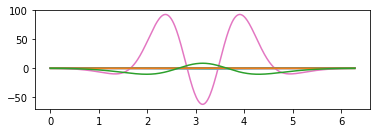

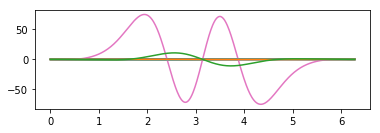

In [589]:
import numpy as np
import matplotlib.pyplot as plt

class Data(object):
    pass
data = Data()
data.phi = np.linspace(0, 2*3.141592653589, 500)
data.rey = []
data.imy = []

i=5
p = expr.subs(dt/dx,1).subs(un,1)
#p = p-p.args[6]
#p = p-p.args[12]

for ex in p.args[1:]:
  ex = (ex.subs(e0,1).subs(e1,1).subs(e2,1).subs(e3,1).subs(e4,1).subs(e5,1)).as_real_imag()
  data.rey.append( sp.lambdify(phi,ex[0],'numpy')(data.phi) )
  data.imy.append( sp.lambdify(phi,ex[1],'numpy')(data.phi) )


for datay in data.rey:
  plt.figure(1)
  plt.subplot(211)
  plt.plot(data.phi,datay)

for datay in data.imy:
  plt.figure(2)
  plt.subplot(212)
  plt.plot(data.phi,datay)
"""
import numpy as np
plt.figure(1)
plt.subplot(211)
plt.plot(data.phi,data.rey[i])
plt.figure(2)
plt.subplot(212)
plt.plot(data.phi,data.imy[i])
"""
plt.show()

#p.args[i+1]


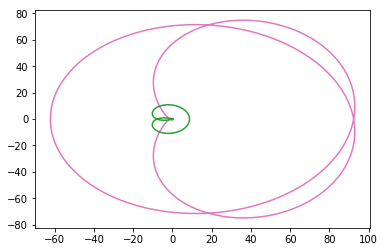

In [590]:
for (re,im) in zip(data.rey,data.imy):
  plt.plot(re,im)

#plt.xlim([-1,1])
#plt.ylim([-1,1])    
plt.show()

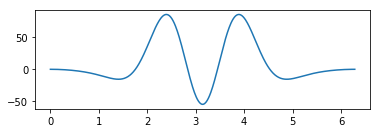

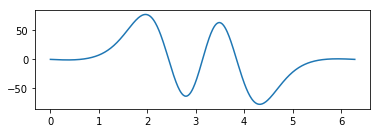

In [591]:
pri = (p.subs(e0,1).subs(e1,1).subs(e2,1).subs(e3,1).subs(e4,1).subs(e5,1)).as_real_imag()
data.pyre = sp.lambdify(phi,pri[0],'numpy')(data.phi)
data.pyim = sp.lambdify(phi,pri[1],'numpy')(data.phi)

plt.figure(1)
plt.subplot(211)
plt.plot(data.phi,data.pyre)
plt.figure(2)
plt.subplot(212)
plt.plot(data.phi,data.pyim)

plt.show()

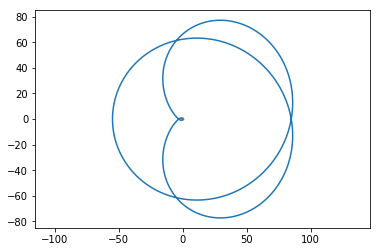

In [592]:
plt.plot(data.pyre,data.pyim)
c1 = plt.Circle((0,0),1.0,color='orange',fill=False)
fig = plt.gcf()
ax = fig.gca()
ax.add_artist(c1)

#plt.xlim([-2,2])
#plt.ylim([-2,2])
plt.axis('equal')
plt.show()